# Model System Notebook 2: Near-edge X-ray Absorption Fine Structure (NEXAFS)

Notebook 2 covers how NEXAFS data is processed and transformed into the optical constants ($\delta, \beta$) used for NRSS simulations. Total electron yield (TEY) NEXAFS data were taken on highly ordered pyrolytic graphite (HOPG). HOPG serves as a proxy material for us to derive the optical constants we use to model the multi-walled carbon nanotubes (MWCNTs).

TEY NEXAFS measures the current flowing to the sample as the incoming x-ray beam hits the sample and kicks off photoelectrons. This current is proportional to a material's $\beta$.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmasher as cmr
c = cmr.sapphire(np.linspace(0,1,7))

NEXAFS data were taken with a fixed polarization 0, while the sample was rotated about the Z-axis. This has the effect of sweeping the x-ray beam polarization from near-normal (20$^\circ$) to parallel with the sample surface (90$^\circ$). A reference scan, where no sample is in the beam, is used to normalize fluctuations in the x-ray beam flux across the series of NEXAFS scans.

$$i_{norm} = \frac{i_{sample}}{i_{sample\ mesh}} * \frac{i_{reference\ mesh}}{i_{reference}}$$

For each NEXAFS scan, the data is read in and multiplied by the normalization factor. Next, the pre-edge background is subtracted, and all scans are normalized by the post-edge. Finally, the scans are written into an xarray DataArray for further processing. 

In [9]:
data_path = './Data/NEXAFS/'
HOPG_scans = [45231, 45232, 45233, 45234, 45235, 45236]
angles = [20, 33, 44, 55, 70, 90]

reference_scan = pd.read_csv(data_path + 'diode_45230.csv')
normalization_factor =  reference_scan['mesh'] / reference_scan['current']

HOPG_data = np.zeros((len(reference_scan['energy']), len(HOPG_scans)))

for i, scan in enumerate(HOPG_scans):
    file = data_path + f'HOPG_{scan}.csv'
    data = pd.read_csv(file)
    data['norm_current'] = data['current'] / data['mesh'] * normalization_factor
    x = data['energy']
    y = data['norm_current']
    idx = (x < 280)
    data['norm_current'] = data['norm_current'] - np.mean(data['norm_current'][idx])
    data['norm_current'] = data['norm_current'] / data['norm_current'].iloc[-1]
    HOPG_data[:,i] = data['norm_current'].values

HOPG = xr.DataArray(HOPG_data, dims=['energy', 'angle'], coords={'energy':reference_scan['energy'], 'angle':angles})

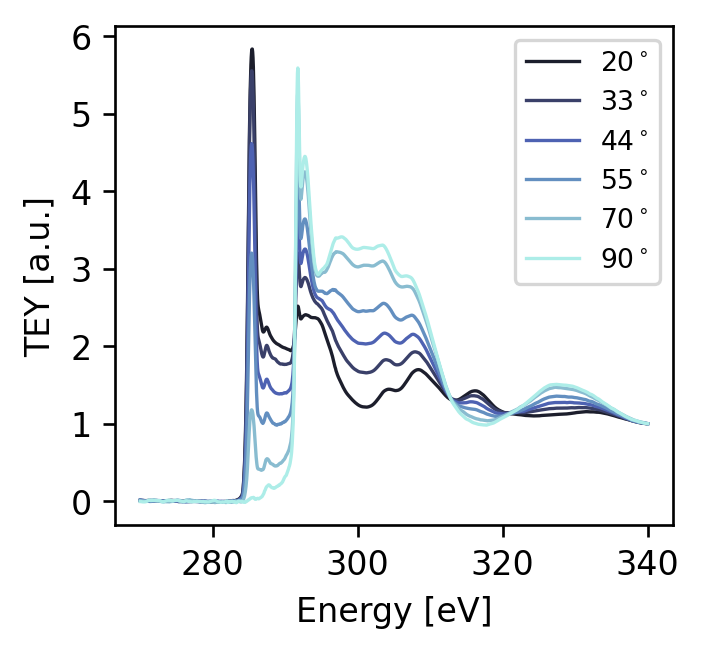

In [10]:
plt.figure(dpi=240, figsize=(3,2.7))
for i, angle in enumerate(HOPG.angle):
    HOPG.sel(angle=angle).plot(color=c[i+1],linewidth=1)
plt.xlabel('Energy [eV]')
plt.ylabel('TEY [a.u.]')
plt.legend(['20$^\circ$','33$^\circ$','44$^\circ$','55$^\circ$','70$^\circ$', '90$^\circ$'],fontsize=8)
plt.title('')
plt.show()

HOPG NEXAFS plotted as a function of energy for all 6 incidence angles. Near-normal, the x-ray polarization is close to parallel with HOPG's $\pi^*$ resonance at 285 eV. As the incidence angle increases to 90$^\circ$, the $\pi^*$ resonance decreases in intensity while the $\sigma^*$ resonance increases.

## NEXAFS extrapolation

We cannot measure TEY NEXAFS at an incidence angle of 0$^\circ$. Instead, we must extrapolate the NEXAFS spectra out to 0$^\circ$. We do this using a second-order polynomial and the 6 measured spectra. At each energy, the data are fit to the second-order polynomial, using the angles transformed into a $cos^2$ dependence. The fit is then evaluated at $1 = cos(0)$ for the extrapolated value, before moving onto the next energy.
$$y = a*x^2 + b*x + c$$
$$x = cos(\theta)^2$$

In [11]:
from scipy.optimize import curve_fit

def poly2(x, a, b, c):
    return a*x**2 + b*x + c

In [15]:
extrapolated_TEY = np.zeros((len(reference_scan['energy']), 1))
x = np.cos(np.deg2rad(angles))**2
for i in range(len(reference_scan['energy'])):
    y = HOPG_data[i,:]
    popt, _ = curve_fit(poly2, x, y)
    extrapolated_TEY[i, 0] = poly2(1, *popt)

angles = [0, 20, 33, 44, 55, 70, 90]
HOPG = xr.DataArray(np.concatenate((extrapolated_TEY, HOPG_data), axis=1), dims=['energy', 'angle'], coords={'energy':reference_scan['energy'], 'angle':angles})

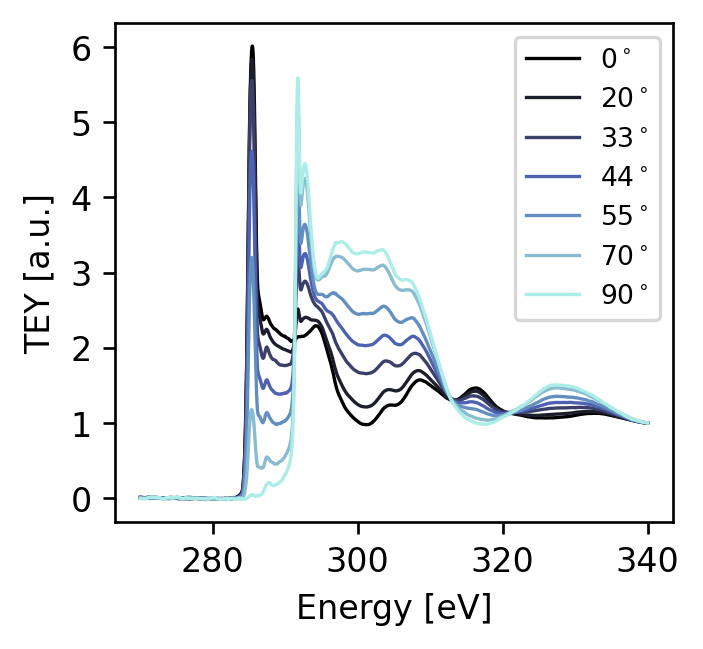

In [16]:
plt.figure(dpi=240, figsize=(3,2.7))
for i, angle in enumerate(HOPG.angle):
    HOPG.sel(angle=angle).plot(color=c[i],linewidth=1)
plt.xlabel('Energy [eV]')
plt.ylabel('TEY [a.u.]')
plt.legend(['0$^\circ$','20$^\circ$','33$^\circ$','44$^\circ$','55$^\circ$','70$^\circ$', '90$^\circ$'],fontsize=8)
plt.title('')
# plt.savefig('Figures/HOPG_TEY.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

The extrapolated data at $\theta = 0$ is plotted with the experimental data.

# Calculate $\delta$ and $\beta$

## Choosing a molecular reference frame

As we discuss in the paper, choosing a molecular reference frame is an important step and it underpins any conclusions in later analysis. In constructing our uniaxial dielectric constant, we chose the extraordinary (unique) axis to be perpendicular to the local HOPG (and thus MWCNT) surface, while the ordinary (degenerate) axes are parallel to the HOPG surface. This choice arises naturally from the symmetry of HOPG.

![Reference Frame](reference_frame.png)

To calculate $\delta$ and $\beta$ from our TEY NEXAFS, we use the [kkcalc](https://github.com/benajamin/kkcalc) library to perform the Kramers-Kronig transform. This library sources optical constant data from the Center for X-Ray Optics (CXRO) [Henke database](https://henke.lbl.gov/optical_constants/).

In [17]:
import sys
sys.path.append('/home/pjd/lib/kkcalc/')

import kkcalc
from kkcalc import data
from kkcalc import kk

def calculate_deltabeta(spectra_e, spectra_abs, chemform, density, merge_low, merge_high):
    # Parse chemical formula and calculate formula mass
    stoichiometry = kk.data.ParseChemicalFormula(chemform)
    formula_mass = data.calculate_FormulaMass(stoichiometry)

    # Calculate Atomic Scattering Factors from Henke Database
    ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
    ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))
    
    idx = spectra_e < merge_low
    spectra_abs[idx] = 0
    # Merge Henke data with NEXAFS
    merged = data.merge_spectra(np.column_stack((spectra_e, spectra_abs)), ASF_E, ASF_Data, merge_points=(merge_low, merge_high), add_background=False, fix_distortions=False, plotting_extras=True)

    # Calculate relativistic correction
    correction = kk.calc_relativistic_correction(stoichiometry)

    # Calculate real component of ASF from merged data
    real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

    
    # Conversion to delta and beta
    delta = data.convert_data(np.column_stack((merged[2][:,0],real)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    beta = data.convert_data(merged[2],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
    
    return delta, beta

Based on our choice of molecular reference frame, we select the 0$^\circ$ NEXAFS to transform into $\delta$ and $\beta$ for the extraordinary axis and the 90$^\circ$ NEXAFS data for the ordinary axis.

In [18]:
chemform = 'C'
density = 2.2
merge_low = 282
merge_high = 340
delta_para, beta_para = calculate_deltabeta(HOPG.energy, HOPG.sel(angle=0).values, chemform, density, merge_low, merge_high)
delta_perp, beta_perp = calculate_deltabeta(HOPG.energy, HOPG.sel(angle=90).values, chemform, density, merge_low, merge_high)

In [19]:
pd_HOPG = pd.DataFrame(data={'BetaPara':beta_para[:,1], 'DeltaPara':delta_para[:,1], 'BetaPerp':beta_perp[:,1], 'DeltaPerp':delta_perp[:,1], 'Energy':HOPG.energy})

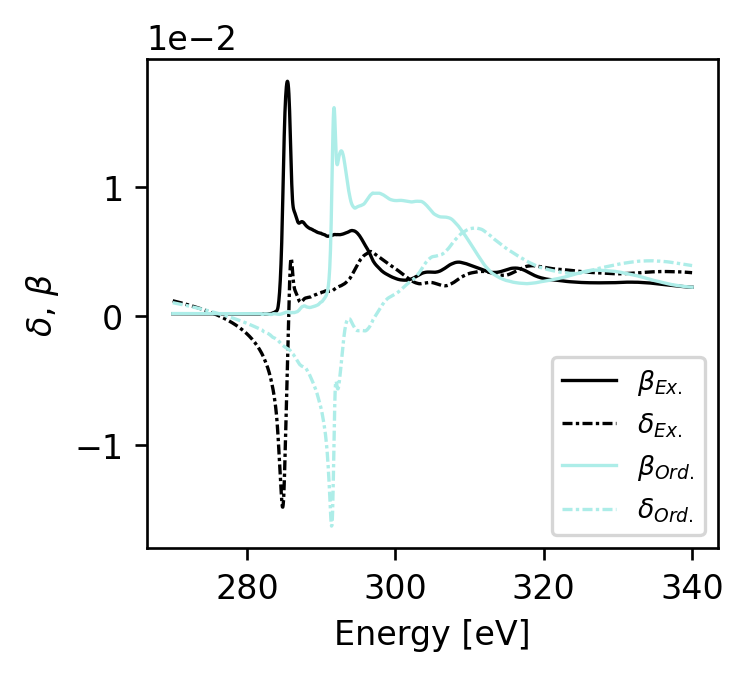

In [20]:
fig, ax = plt.subplots(dpi=240, figsize=(3, 2.7),layout='constrained')

pd_HOPG.plot(x='Energy',y='BetaPara', ax=ax, linewidth=1, color=c[0])
pd_HOPG.plot(x='Energy',y='DeltaPara', ax=ax, linewidth=1, color=c[0], linestyle=(0, (3, 1, 1, 1)))
pd_HOPG.plot(x='Energy',y='BetaPerp', ax=ax, linewidth=1, color=c[-1])
pd_HOPG.plot(x='Energy',y='DeltaPerp', ax=ax, linewidth=1, color=c[-1], linestyle=(0, (3, 1, 1, 1)))

plt.xlabel('Energy [eV]')
plt.ylabel(r'$\delta$, $\beta$')
plt.legend([r'$\beta_{Ex.}$', r'$\delta_{Ex.}$', r'$\beta_{Ord.}$', r'$\delta_{Ord.}$'], fontsize=8, loc='lower right')
ax.ticklabel_format(axis='y', style='sci', scilimits=[0,0])
# plt.savefig('Figures/deltabeta.pdf', format='pdf', bbox_inches='tight')
plt.show()

After performing the Kramers-Kronig transform, we plot $\delta$ and $\beta$ for the ordinary and extraordinary axes of our uniaxial dielectric function.

We can also save the optical constants to a csv for further use.

In [21]:
pd_HOPG.to_csv('Data/MWCNT_opts.csv',index=False)